In [1]:
import sys
print(sys.executable)
import torch
print (torch.__version__)
import torchvision
print(torchvision.__version__)


C:\Users\pearl\Anaconda3\envs\pytorchEnv\python.exe
0.4.0
0.2.1


In [ ]:
import argparse
import numpy
parser=argparse.ArgumentParser()
FLAGS=parser.parse_args(args=[])
FLAGS.batchsize=128
FLAGS.w_printepoch=1
FLAGS.init_lr=1e-4
FLAGS.lrchange=0.9
FLAGS.BreakBasedLr_lr=1e-8
FLAGS.init_alpha=0

FLAGS.azepoch=50
FLAGS.w_epoch=1000
FLAGS.alpha_inf= 1e+13

FLAGS.reglambda=1
FLAGS.datafold='./data' 
#FLAGS.datafold='./data' 
FLAGS.resume_name='mnist_lenet5_map_avgover_alpha0-statedict-bestvalid.ckpt'   

FLAGS.save_name='mnist_lenet5_ard_valid_lambda_resume_0'


In [ ]:
import torchvision.datasets
import torchvision.transforms

transform1=torchvision.transforms.ToTensor()
transform2=lambda x: 2*(x-0.5)
transform12=torchvision.transforms.Compose([transform1,transform2])
datasets_mnist_train=torchvision.datasets.MNIST(FLAGS.datafold, train=True, download=False, transform=transform12)
datasets_mnist_test=torchvision.datasets.MNIST(FLAGS.datafold, train=False, transform=transform12)

In [ ]:
import torch.utils.data.dataset
import torch.utils.data
import torch

test_loader=torch.utils.data.DataLoader(datasets_mnist_test,batch_size=FLAGS.batchsize )
N=50000
train_subset=torch.utils.data.dataset.Subset(datasets_mnist_train,range(N))
valid_subset=torch.utils.data.dataset.Subset(datasets_mnist_train,range(N,60000))
train_loader=torch.utils.data.DataLoader(train_subset, batch_size=FLAGS.batchsize,shuffle=True) 
valid_loader=torch.utils.data.DataLoader(valid_subset, batch_size=FLAGS.batchsize )


In [ ]:
import torch.nn
import torch
import torch.autograd
import math
import random
import numpy


random.seed(1)
numpy.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class History(object):
    def __init__(self):
        self.loss=[]
        self.regloss=[]
        self.totalloss=[]
        self.testerr=[] 

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [ ]:
class ARDDense(torch.nn.modules.Module):
    def __init__(self, in_features, out_features,initalpha):
        super(ARDDense, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor( out_features,in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))        
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        
        self.dim = in_features
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)    
        
        self.index=torch.arange(self.dim).cuda().long()
        self.isnormal=torch.ones(self.dim).byte().cuda()
            
    def forward(self, inputx):    
        o=torch.nn.functional.linear(inputx[:,self.index], self.weights[:,self.index],self.bias)    
        return o
    
    def regularization(self): 
        reg=torch.sum(self.weights[:,self.index].pow(2)*self.alpha[self.isnormal])
        return 0.5*reg
    
    def update_alpha(self):
        self.alpha=1.0/torch.mean( self.weights.pow(2),0).data
            
            
    def set_zeroweight(self):
        isinf=(self.alpha>=FLAGS.alpha_inf)
        set0index=isinf.nonzero()
        if set0index.size(0)!=0: # has some nonzero==has some inf
            self.weights.data.index_fill_(1,set0index.squeeze(),0)
        self.isnormal=(self.alpha<FLAGS.alpha_inf)
        self.index=self.isnormal.nonzero().squeeze()
        
    def left_dim(self):
        return self.index.numel() #self.index.size(0)


In [ ]:
class ARDConv2d(torch.nn.modules.Module):
    def __init__(self, in_channels, out_channels,initalpha,kernelsize,padding):
        super(ARDConv2d, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernelsize,kernelsize))
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        self.padding=padding
        
        self.dim = out_channels
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)   
        
        self.index=torch.arange(self.dim).cuda().long()
        self.isnormal=torch.ones(self.dim).byte().cuda()
        
    def forward(self, input_):# batchsize,inchannel, 28x28
        output = torch.nn.functional.conv2d(input_, self.weights*self.isnormal.float().view(-1,1,1,1) , self.bias*self.isnormal.float(),padding=self.padding)    
        return output
        
    def regularization(self):  
        reg=torch.sum(self.weights[self.index,:,:,:].pow(2)* (self.alpha[self.isnormal].view(-1,1,1,1)))
        return 0.5*reg
    
    def update_alpha(self):
        self.alpha=1.0/torch.mean( self.weights.pow(2).view(self.dim,-1),1).data 
        
    def set_zeroweight(self):
        isinf=(self.alpha>=FLAGS.alpha_inf)
        set0index=isinf.nonzero()
        if set0index.size(0)!=0: # has some nonzero==has some inf
            self.weights.data.index_fill_(0,set0index.squeeze(),0)
        self.isnormal=(self.alpha<FLAGS.alpha_inf)
        self.index=self.isnormal.nonzero().squeeze()
        
    def left_dim(self):
        return self.index.numel() #self.index.size(0)
       

In [ ]:
class LeNet5_MNIST(torch.nn.Module):
    def __init__(self):
        super(LeNet5_MNIST, self).__init__()        
        convs=[ARDConv2d(1,20,FLAGS.init_alpha,5,0),torch.nn.ReLU(), torch.nn.MaxPool2d(2),
               ARDConv2d(20,50,FLAGS.init_alpha,5,0),torch.nn.ReLU(), torch.nn.MaxPool2d(2) ]
        self.convs=torch.nn.Sequential(*convs).cuda()         
        fcs = [ARDDense(800, 500,FLAGS.init_alpha), torch.nn.ReLU(),
               ARDDense(500, 10,FLAGS.init_alpha)]
        self.fcs = torch.nn.Sequential(*fcs).cuda()
             
    def left_conv_dim(self):
        leftnode=[1]
        for m in self.modules():
            if isinstance(m, ARDConv2d):
                leftnode.append(m.left_dim())
        return leftnode
    
    def left_linear_dim(self):
        leftnode=[]
        for m in self.modules():
            if isinstance(m, ARDDense):
                leftnode.append(m.left_dim())
        leftnode.append(10)
        return leftnode
    
    def left_weightn(self):
        leftcovnode=self.left_conv_dim()
        leftlinearnode=self.left_linear_dim()
        leftedge=0
        for tmpi in range(len(leftcovnode)-1):
            leftedge+=leftcovnode[tmpi]*leftcovnode[tmpi+1]*5*5
        for tmpi in range(len(leftlinearnode)-1):
            leftedge+=leftlinearnode[tmpi]*leftlinearnode[tmpi+1]
        return leftcovnode,leftlinearnode,leftedge
    
    def forward(self, x):
        o = self.convs(x)
        o = o.view(o.size(0), -1)
        o=self.fcs(o)
        return o
    
    def regularization(self):
        reg = 0.0
        for m in self.modules():
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                reg += m.regularization() 
        return reg
    
    def  update_alpha(self):
        for m in model.modules():  # weight -> alpha
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                m.update_alpha()
                
    def set_zeroweight(self):
        for m in self.modules():
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                m.set_zeroweight()



In [ ]:
model = LeNet5_MNIST()
model = model.cuda()
lossfunc=torch.nn.CrossEntropyLoss()

In [ ]:
leftcovnode,leftlinearnode,fullModelWeightNumber=model.left_weightn()
for n in range(len(leftcovnode)-1):
    print(leftcovnode[n],end='-')
print(leftcovnode[-1],end=' ')
for n in range(len(leftlinearnode)-1):
    print(leftlinearnode[n],end='-')
print(leftlinearnode[-1],end=' ')
print(fullModelWeightNumber)

In [ ]:
def oneThroughdataset_test(dataloader ):    
    loss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.eval()       
    for ibatch, (input_, target) in enumerate(dataloader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)
        loss = lossfunc(output, target_var)       
        acc = accuracy(output.data, target, topk=(1,))[0]    
        loss_avg.update(loss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
    return loss_avg.avg, predictionErr_avg.avg


In [ ]:
def oneThroughdataset_train(optimizer,reglambda):   
    loss_avg = AverageMeter()
    regloss_avg = AverageMeter()
    totalloss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.train()
    for ibatch, (input_, target) in enumerate(train_loader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)        
        loss = lossfunc(output, target_var)
        regloss=model.regularization()/N
        totalloss = loss +  reglambda*regloss   
        totalloss = totalloss.cuda()
        acc = accuracy(output.data, target, topk=(1,))[0]   
        
        loss_avg.update(loss.data.item(), input_.size(0))
        regloss_avg.update(regloss.data.item(), input_.size(0))
        totalloss_avg.update(totalloss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
        
        optimizer.zero_grad()
        totalloss.backward()
        optimizer.step()
          
    return loss_avg.avg, regloss_avg.avg,  totalloss_avg.avg, predictionErr_avg.avg

In [ ]:
import numpy
def z_step(history,aziter,reglambda,learningrate):
    last1,last2=1e+10,1e+10
       
    optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': learningrate}])
    for w_iter in range(FLAGS.w_epoch):    
        meanloss,meanregloss,meantotalloss,predictionerr  =oneThroughdataset_train(optimizer,reglambda)
        testloss,testerr=oneThroughdataset_test(test_loader)
            
        history.loss.append( meanloss )
        history.regloss.append( meanregloss)
        history.totalloss.append(meantotalloss )
        history.testerr.append(testerr)
                    
        print(' w {} {:.1e} {:.1e}={:.1e} err%Trn test={:.2f} {:.2f} lr={:.1e}'.format(w_iter,
                   meanloss,meanregloss,meantotalloss,predictionerr,testerr,learningrate) ) 
        
        if  (last2-last1)/last2<0.001 and (last1-meantotalloss)/last1<0.001:
            learningrate=learningrate* FLAGS.lrchange 
            optimizer.param_groups[0]['lr']=learningrate

        if learningrate < FLAGS.BreakBasedLr_lr:
            break
            
        if meantotalloss==0:
            break
            
        last2=last1
        last1=meantotalloss 
    return history

In [ ]:
class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

In [ ]:
azBeforeHistory=CompressionHistory()
azAfterHistory=CompressionHistory()
whistory=History()
azstart=0
for aziter in range(azstart,FLAGS.azepoch):
    # initialize w and alpha
    if aziter==0:
        #reglambda=1
        #learningrate=1e-3
        #print('az {} lr={:.1e} reglambda={:.1e}'.format(aziter,learningrate,reglambda))
        #whistory=z_step(whistory,aziter,reglambda,learningrate)
        #torch.save(whistory, './ckpt/{}-whistory.ckpt'.format(FLAGS.save_name) )
        resume_dict = torch.load(FLAGS.resume_name, map_location='cpu')
        ard_keys, resume_keys = list(model.state_dict().keys()), list(resume_dict['statedict'].keys())
        for i in range(len(ard_keys)):
            model.state_dict()[ard_keys[i]].copy_(resume_dict['statedict'][resume_keys[i]])
    
    
    
    testloss,testerr=oneThroughdataset_test(test_loader)
    validloss,validerr=oneThroughdataset_test(valid_loader)
    leftcovnode,leftlinearnode,leftnumber=model.left_weightn()
    edgeratio=leftnumber*100/fullModelWeightNumber
    azBeforeHistory.testerr.append(testerr)
    azBeforeHistory.edgeratio.append(edgeratio)
    azBeforeHistory.validerr.append(validerr)
    azBeforeHistory.linearnode.append(leftlinearnode)
    azBeforeHistory.convnode.append(leftcovnode)
    azBeforeHistory.edge.append(leftnumber)
    
    print('az {} init'.format(aziter),end=' ')
    for n in range(len(leftcovnode)-1):
        print(leftcovnode[n],end='-')
    print(leftcovnode[-1],end=' ')
    for n in range(len(leftlinearnode)-1):
        print(leftlinearnode[n],end='-')
    print(leftlinearnode[-1],end=' ')
    print('ratio={} {:.2f}%'.format(leftnumber,edgeratio),end= ' ')
    print('validerr testerr={:.2f} {:.2f}'.format( validerr,testerr) )
    
    model.update_alpha()
    model.set_zeroweight()    
    testloss,testerr=oneThroughdataset_test(test_loader)
    validloss,validerr=oneThroughdataset_test(valid_loader)
    leftcovnode,leftlinearnode,leftnumber=model.left_weightn()
    edgeratio=leftnumber*100/fullModelWeightNumber
    azAfterHistory.testerr.append(testerr)
    azAfterHistory.edgeratio.append(edgeratio)
    azAfterHistory.validerr.append(validerr)
    azAfterHistory.convnode.append(leftcovnode)
    azAfterHistory.linearnode.append(leftlinearnode)
    azAfterHistory.edge.append(leftnumber)
    
    print('az {} alpha_inf={:.1e}'.format(aziter,FLAGS.alpha_inf),end=' ')
    for n in range(len(leftcovnode)-1):
        print(leftcovnode[n],end='-')
    print(leftcovnode[-1],end=' ')
    for n in range(len(leftlinearnode)-1):
        print(leftlinearnode[n],end='-')
    print(leftlinearnode[-1],end=' ')
    print('ratio={} {:.2f}%'.format(leftnumber,edgeratio),end= ' ')
    print('validerr testerr={:.2f} {:.2f}'.format( validerr,testerr) )
    compresshistory=dict()
    compresshistory['before']=azBeforeHistory
    compresshistory['after']=azAfterHistory
    torch.save(compresshistory,'{}-history.ckpt'.format(FLAGS.save_name))

    
    # alpha ->  weight
    reglambda=FLAGS.reglambda
    learningrate=FLAGS.init_lr
    print('az {} lr={:.1e} reglambda={:.1e}'.format(aziter,learningrate,reglambda))
    whistory=z_step(whistory,aziter,reglambda,learningrate)
    torch.save(whistory, './ckpt/{}-whistory.ckpt'.format(FLAGS.save_name) )
 

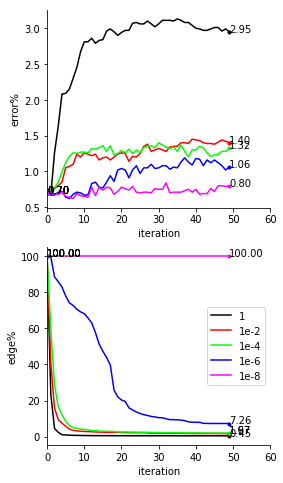

In [13]:
filelist=[    
     'ckpt/mnist_lenet5_ard_valid_lambda_resume_0-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_2-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_4-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_6-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_8-history.ckpt', 
    
]
legendlist=[
'1',
'1e-2',
'1e-4',
'1e-6',
'1e-8',
]

colorlist=[
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    #[1,1,0],
    [1,0,1],
    [0,1,1],
    
]

class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

import torch
import matplotlib.pyplot

fig,ax=matplotlib.pyplot.subplots(2,1,figsize=(4,8))
ax[0].set_ylabel('error%' )
ax[0].set_xlabel('iteration')
#ax.set_ylim([1.25,2])
#ax.set_xlim([0,10])
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].testerr
    lline=ax[0].plot(y ,color=colorlist[idd])
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].testerr
    x=len(y)-1
    lline=ax[0].plot(x,y[x],'.',color=colorlist[idd])
    ax[0].annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
    x=0
    lline=ax[0].plot(x,y[x],'.',color=colorlist[idd])
    ax[0].annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim([0,60])
#ax[0].yaxis.set_label_coords(-0.2, 0.5)
#ax[0].legend(legendlist) 

ax[1].set_ylabel('edge%' )
ax[1].set_xlabel('iteration')
#ax.set_ylim([1.25,2])
#ax.set_xlim([0,10])
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].edgeratio
    lline=ax[1].plot(y ,color=colorlist[idd]) 
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].edgeratio
    x=len(y)-1
    lline=ax[1].plot(x,y[x],'.',color=colorlist[idd])
    ax[1].annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
    x=0
    lline=ax[1].plot(x,y[x],'.',color=colorlist[idd])
    ax[1].annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
#ax[1].yaxis.set_label_coords(-0.2, 0.5)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlim([0,60])
ax[1].legend(legendlist) 
#ax[1].yaxis.set_ticks_position("right") 
#ax[1].yaxis.set_label_position("right") 
#matplotlib.pyplot.legend(legendlist ) 
#matplotlib.pyplot.subplots_adjust(wspace=0.35)
matplotlib.pyplot.savefig('mnist_lenet5_lambda_resume.pdf', bbox_inches='tight')    

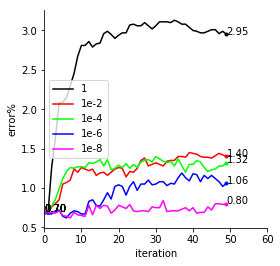

In [14]:
filelist=[    
     'ckpt/mnist_lenet5_ard_valid_lambda_resume_0-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_2-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_4-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_6-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_8-history.ckpt', 
    
]
legendlist=[
'1',
'1e-2',
'1e-4',
'1e-6',
'1e-8',
]

colorlist=[
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    #[1,1,0],
    [1,0,1],
    [0,1,1],
    
]

class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

import torch
import matplotlib.pyplot

fig,ax=matplotlib.pyplot.subplots( figsize=(4,4))
ax.set_ylabel('error%' )
ax.set_xlabel('iteration')
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].testerr
    lline=ax.plot(y ,color=colorlist[idd])
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].testerr
    x=len(y)-1
    lline=ax.plot(x,y[x],'.',color=colorlist[idd])
    ax.annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
    x=0
    lline=ax.plot(x,y[x],'.',color=colorlist[idd])
    ax.annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,60]) 
ax.legend(legendlist,loc=6) 
matplotlib.pyplot.savefig('mnist_lenet5_lambda_error.pdf', bbox_inches='tight')    

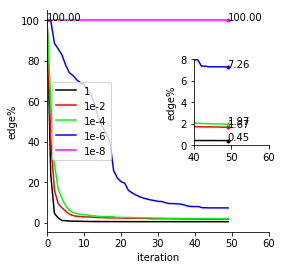

In [15]:
filelist=[    
     'ckpt/mnist_lenet5_ard_valid_lambda_resume_0-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_2-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_4-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_6-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_8-history.ckpt', 
    
]
legendlist=[
'1',
'1e-2',
'1e-4',
'1e-6',
'1e-8',
]

colorlist=[
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    #[1,1,0],
    [1,0,1],
    [0,1,1],
    
]

class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

import torch
import matplotlib.pyplot

fig=matplotlib.pyplot.figure(figsize=(4,4)) 
left, bottom, width, height = 0, 0, 0.77, 0.77
ax= fig.add_axes([left, bottom, width, height])
ax.set_xlim([0,60])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('edge%' )
ax.set_xlabel('iteration') 
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].edgeratio
    lline=ax.plot(y ,color=colorlist[idd]) 

ax.legend(legendlist,loc=6) 

idd=4
ckptfile=filelist[idd]
compresshistory=torch.load(ckptfile)
y=compresshistory['after'].edgeratio
x=len(y)-1
lline=ax.plot(x,y[x],'.',color=colorlist[idd])
ax.annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
x=0
lline=ax.plot(x,y[x],'.',color=colorlist[idd])
ax.annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))


left, bottom, width, height = 0.51, 0.3, 0.26, 0.3
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_ylim([0,8])
ax2.set_ylabel('edge%' )
fromiter=40
ax2.set_xlim([fromiter,60])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)
    y=compresshistory['after'].edgeratio
    xlist=[x for x in range(fromiter,len(y))]
    lline=ax2.plot( xlist,y[fromiter:] ,color=colorlist[idd]) 
    lline=ax2.plot(xlist[-1],y[-1],'.',color=colorlist[idd])
    ax2.annotate( '{:.2f}'.format(y[-1]),xy=(xlist[-1],y[-1]))

matplotlib.pyplot.savefig('mnist_lenet5_lambda_edge.pdf', bbox_inches='tight')    


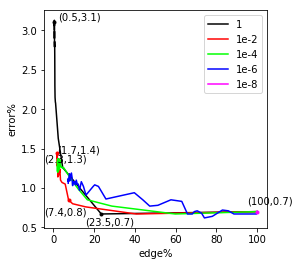

In [16]:
def firstErrGivenEdge(preErr,etotalpercent,givenEdge):
    epoch,err,edge=-1,100,100
    for i in range(len(preErr)):
        if etotalpercent[i]<=givenEdge:
            epoch=i
            err=preErr[i]
            edge=etotalpercent[i]
            break
    return epoch,err,edge

class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

import matplotlib.pyplot
import torch
import numpy

filelist=[    
     'ckpt/mnist_lenet5_ard_valid_lambda_resume_0-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_2-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_4-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_6-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_8-history.ckpt', 
    
]
legendlist=[
'1',
'1e-2',
'1e-4',
'1e-6',
'1e-8',
]

colorlist=[
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    #[1,1,0],
    [1,0,1],
    [0,1,1],
    
]

errlistlist=[]
edgelistlist=[]
for idd in range(len(filelist)) :
    file=filelist[idd]
    compresshistory=torch.load( file )
    errhistory=compresshistory['after'].testerr
    edgehistory=compresshistory['after'].edgeratio
    errlist=[]
    edgelist=[]
    rangeedge=edgehistory.copy()
    rangeedge.sort()
    for edgetmp in rangeedge:#numpy.arange(0,101,0.01):
        epoch,err,edge=firstErrGivenEdge(errhistory,edgehistory,edgetmp)
        if epoch>=0:
            errlist.append(err)
            edgelist.append(edge)
    errlistlist.append(errlist)
    edgelistlist.append(edgelist)
    
    
for idd in range(len(errlistlist)):
    edgelist,errlist=edgelistlist[idd],errlistlist[idd]
    for posid in range(len(edgelist)):
        x,y=edgelist[posid],errlist[posid]
        #print(x,y)

fig,ax=matplotlib.pyplot.subplots(figsize=(4,4))
for idd in range(len(errlistlist)):
    edgelist,errlist=edgelistlist[idd],errlistlist[idd]
    ax.plot(edgelist,errlist,'-',color=colorlist[idd])
    ax.set_xlabel('edge%')
    ax.set_ylabel('error%')
    


idd,posid=4,49
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.0f},{:.1f})'.format(x,y),xy=(x-5,y+0.1))


idd,posid=0,5
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x+2,y+0.02))

idd,posid=0,48
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x-8,y-0.14))

idd,posid=1,45
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x-12,y-0.2))

idd,posid=1,2
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x,y))

idd,posid=2,19
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x-7,y))


ax.legend(legendlist)
matplotlib.pyplot.savefig('lenet5_lambda_error_edge.pdf', bbox_inches='tight')    

 


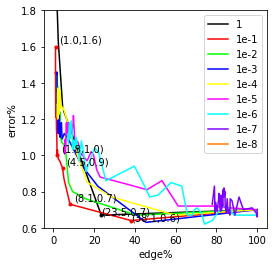

In [17]:
def firstErrGivenEdge(preErr,etotalpercent,givenEdge):
    epoch,err,edge=-1,100,100
    for i in range(len(preErr)):
        if etotalpercent[i]<=givenEdge:
            epoch=i
            err=preErr[i]
            edge=etotalpercent[i]
            break
    return epoch,err,edge

class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

import matplotlib.pyplot
import torch
import numpy

filelist=[    
     'ckpt/mnist_lenet5_ard_valid_lambda_resume_0-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_1-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_2-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_3-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_4-history.ckpt',
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_5-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_6-history.ckpt',
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_7-history.ckpt', 
    'ckpt/mnist_lenet5_ard_valid_lambda_resume_8-history.ckpt', 
    
]
legendlist=[
'1',
'1e-1',
'1e-2',
'1e-3',
'1e-4',
'1e-5',
'1e-6',
'1e-7',
'1e-8',
]

colorlist=[
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    [1,1,0],
    [1,0,1],
    [0,1,1],
    [0.5,0,1],
    [1,0.5,0],
    [0,0.5,1]
    
]

errlistlist=[]
edgelistlist=[]
for idd in range(len(filelist)) :
    file=filelist[idd]
    compresshistory=torch.load( file )
    errhistory=compresshistory['after'].testerr
    edgehistory=compresshistory['after'].edgeratio
    errlist=[]
    edgelist=[]
    rangeedge=edgehistory.copy()
    rangeedge.sort()
    for edgetmp in rangeedge:#numpy.arange(0,101,0.01):
        epoch,err,edge=firstErrGivenEdge(errhistory,edgehistory,edgetmp)
        if epoch>=0:
            errlist.append(err)
            edgelist.append(edge)
    errlistlist.append(errlist)
    edgelistlist.append(edgelist)
    
    
for idd in range(len(errlistlist)):
    edgelist,errlist=edgelistlist[idd],errlistlist[idd]
    for posid in range(len(edgelist)):
        x,y=edgelist[posid],errlist[posid]
        #print(x,y)

fig,ax=matplotlib.pyplot.subplots(figsize=(4,4))
for idd in range(len(errlistlist)):
    edgelist,errlist=edgelistlist[idd],errlistlist[idd]
    ax.plot(edgelist,errlist,'-',color=colorlist[idd])
    ax.set_xlabel('edge%')
    ax.set_ylabel('error%')
    

idd,posid=1,0
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x+2,y+0.02))

idd,posid=1,41
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x+2,y+0.02))
   
idd,posid=1,45
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x+2,y+0.02))

idd,posid=1,47
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x+2,y+0.02))
 
idd,posid=1,48
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x,y))
 
idd,posid=0,48
edgelist,errlist=edgelistlist[idd],errlistlist[idd]
x,y=edgelist[posid],errlist[posid]
ax.plot(x,y,'.',color=colorlist[idd])
ax.annotate( '({:.1f},{:.1f})'.format(x,y),xy=(x,y))

ax.legend(legendlist)
ax.set_ylim([0.6,1.8])
matplotlib.pyplot.savefig('lenet5_lambda_error_edge_9.pdf', bbox_inches='tight')    

 
